<a href="https://colab.research.google.com/github/skashyapsri/Absorbance-Prediction-Using-ML/blob/main/EVOO_Pigment_Analysis_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVOO Pigment Analysis using Deep Learning


## Import Libraries

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
import torch.optim as optim

## Load and Prepare Data

In [46]:
evoo_samples = pd.read_csv('https://raw.githubusercontent.com/sandroj87/EVOODec/refs/heads/main/evoodec/spectra/rapeseed_oil.csv', delimiter=';')
pigments_data = pd.read_csv('https://raw.githubusercontent.com/sandroj87/EVOODec/refs/heads/main/evoodec/pigments/pigments.csv', delimiter=';', comment='#')
MW = pigments_data.iloc[0, 1:].astype(float).values  # g/mol
pigments_data = pigments_data.iloc[2:].reset_index(drop=True)

evoo_samples.columns = ['Wavelength', 'Absorbance']
pigments_data = pigments_data.rename(columns={'Wavelength (nm)': 'Wavelength'})

evoo_samples['Wavelength'] = pd.to_numeric(evoo_samples['Wavelength'], errors='coerce')
pigments_data['Wavelength'] = pd.to_numeric(pigments_data['Wavelength'], errors='coerce')

evoo_samples = evoo_samples.dropna()
pigments_data = pigments_data.dropna()

b = 1.0  # in cm
EVOO_DENSITY = 0.9 # in g/ml

## Define Helper Functions


In [47]:
def apply_baseline_correction(absorbance):
    return absorbance - np.min(absorbance)

def select_wavelength_range(data, start, end):
    return data[(data['Wavelength'] >= start) & (data['Wavelength'] <= end)]

## Preprocess Data

In [48]:
wavelength_start, wavelength_end = 390, 720

evoo_samples = select_wavelength_range(evoo_samples, wavelength_start, wavelength_end)
pigments_data = select_wavelength_range(pigments_data, wavelength_start, wavelength_end)

wavelengths = evoo_samples['Wavelength'].values
A_exp = evoo_samples['Absorbance'].values.astype(float)

baseline_correction = True
if baseline_correction:
    A_exp = apply_baseline_correction(A_exp)

epsilon = pigments_data.iloc[:, 1:].astype(float).values.T
epsilon = np.maximum(epsilon, 0)
epsilon_max = np.max(epsilon, axis=1, keepdims=True)
epsilon_max[epsilon_max == 0] = 1
epsilon_normalized = epsilon / epsilon_max

## Define PyTorch Model

In [49]:
class DeconvolutionModel(nn.Module):
    def __init__(self, num_pigments):
        super(DeconvolutionModel, self).__init__()
        self.concentrations = nn.Parameter(torch.rand(num_pigments))

    def forward(self, epsilon):
        positive_concentrations = nn.functional.relu(self.concentrations)
        return torch.matmul(positive_concentrations, epsilon) * b

## Define Training Function

In [50]:
def train_model(A_exp, epsilon, num_epochs=5000, learning_rate=0.001):
    model = DeconvolutionModel(epsilon.shape[0])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    A_exp_tensor = torch.FloatTensor(A_exp)
    epsilon_tensor = torch.FloatTensor(epsilon)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        A_calc = model(epsilon_tensor)
        loss = criterion(A_calc, A_exp_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 500 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    return model

## Train the Model and Calculate Results

In [51]:
model = train_model(A_exp, epsilon_normalized)

final_concentrations = nn.functional.relu(model.concentrations).detach().numpy()

A_calc = np.dot(final_concentrations, epsilon_normalized) * b
r2 = r2_score(A_exp, A_calc)
print(f"R-square      = {r2:.6f}")

Epoch [500/5000], Loss: 0.3035
Epoch [1000/5000], Loss: 0.1141
Epoch [1500/5000], Loss: 0.0671
Epoch [2000/5000], Loss: 0.0489
Epoch [2500/5000], Loss: 0.0360
Epoch [3000/5000], Loss: 0.0269
Epoch [3500/5000], Loss: 0.0207
Epoch [4000/5000], Loss: 0.0166
Epoch [4500/5000], Loss: 0.0138
Epoch [5000/5000], Loss: 0.0118
R-square      = 0.993919


## Plot Results

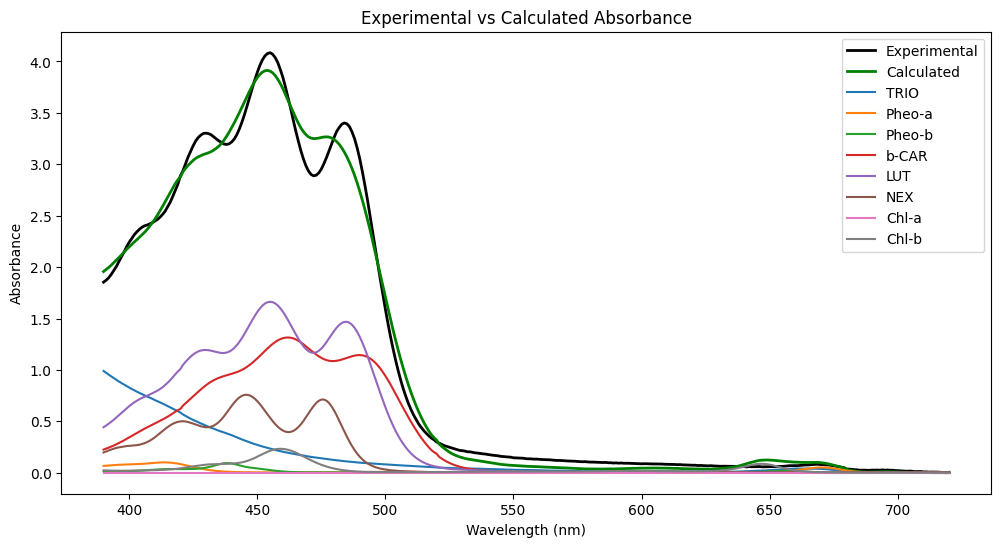

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(wavelengths, A_exp, 'k-', label='Experimental', linewidth=2)
plt.plot(wavelengths, A_calc, 'g-', label='Calculated', linewidth=2)
for i, name in enumerate(pigments_data.columns[1:]):
    plt.plot(wavelengths, final_concentrations[i] * epsilon_normalized[i] * b, label=name)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.legend()
plt.title('Experimental vs Calculated Absorbance')
plt.show()

## Calculate and Print Final Concentrations

In [54]:
MG_PER_KG = 1e6
pigment_names = pigments_data.columns[1:].tolist()

concentrations = []
for i, name in enumerate(pigment_names):
    epsilon_max_i = np.max(epsilon[i])
    conc = (final_concentrations[i] * MW[i] * 1000 / EVOO_DENSITY)
    concentrations.append(conc)

print("\nFinal results:   DL Model")
print(f"R-square      = {r2:.6f}")
print("    PIGMENT CONCENTRATION")
print("-------------------------------")
total_concentration = 0
for name, conc in zip(pigment_names, concentrations):
  print(f"{name:<12} = {conc:9.3f} mg/kg")
  total_concentration += conc
print("-------------------------------")
print(f"PIGMENT TOTAL = {total_concentration:9.3f} mg/kg")


Final results:   DL Model
R-square      = 0.993919
    PIGMENT CONCENTRATION
-------------------------------
TRIO         = 973593.170 mg/kg
Pheo-a       = 97672.053 mg/kg
Pheo-b       = 92491.592 mg/kg
b-CAR        = 784709.465 mg/kg
LUT          = 1050995.432 mg/kg
NEX          = 506001.039 mg/kg
Chl-a        =     0.000 mg/kg
Chl-b        = 234545.930 mg/kg
-------------------------------
PIGMENT TOTAL = 3740008.681 mg/kg
